In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_columns", None)
from functions import *

### Add Labels to Data

In [14]:
df = pd.read_parquet('Data/Cleaned/more_data_post_feat_engineering.parquet')
labels = pd.read_parquet('Data/Cleaned/more_labels.parquet')

df = df.merge(labels[['GEOID','pred_year','label']], on=['GEOID','pred_year'], how='left')
df

,GEOID,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,pred_year,lag_vulnerable,label
0,36005000100,-0.068661,0.035685,0.028985,0.001017,0.199477,0.045892,-0.017763,0.035731,0.022690,0.021284,0.054678,-0.014333,0.065448,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006464,0.018035,0.277300,-0.000033,0.000000,-0.024075,-0.124830,0.449510,0.002733,0.025448,0.010323,-0.014150,-0.050057,0.005722,0.049193,0.004397,1.089373,0.008277,-0.005696,12.906525,-0.007878,-0.034566,0.0,0.040565,0.013164,0.000000,0.000000,0.144316,0.082033,0.0,0.0,2020,1.000000,2
1,36005000200,0.034962,0.218237,0.201764,-0.026817,-0.211255,-0.143559,-0.051058,0.005439,0.075584,0.050176,0.071833,-0.077578,-0.105136,0.033405,-0.021183,0.000000,0.138279,-0.377954,0.214509,-0.026615,-0.298942,-0.017225,0.000000,0.009071,0.057625,0.148837,-0.027422,0.023382,0.149468,0.009212,-0.077517,0.030404,-0.003322,0.049306,1.106573,0.001691,0.311270,0.000000,-0.021834,-0.021378,0.0,0.039684,0.000384,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2020,0.689655,0
2,36005000400,0.034124,0.786830,0.168444,-0.006987,0.000000,-0.086546,0.085892,-0.119376,0.065526,-0.033501,0.236460,-0.107590,-0.004790,0.028070,-0.028604,-0.187822,-0.041648,2.037930,0.255629,0.070771,0.083326,-0.038641,0.000000,-0.016291,0.000209,0.032225,0.000973,0.054771,0.012176,0.007979,-0.229897,0.011434,0.009918,0.015270,-0.394797,-0.017437,1.049936,0.000000,-0.060346,-0.014822,0.0,0.065020,-0.002948,0.000000,0.070962,0.000000,0.051681,0.0,0.0,2020,0.620690,0
3,36005001600,0.028238,0.105534,0.119549,-0.037455,0.000000,-0.068067,0.070625,-0.016419,0.270917,-0.013170,0.057567,0.232766,-0.104326,-0.015358,-0.022066,0.000000,0.312918,-0.095215,0.168040,0.005470,0.000000,0.000000,0.000000,0.013476,0.015757,-0.076782,-0.031302,0.045230,0.142282,0.004117,-0.403649,0.008068,0.023547,-0.013855,7.142181,0.003578,0.013124,0.000000,-0.017877,-0.040687,0.0,0.063187,0.029170,0.000000,0.069444,0.000000,0.106212,0.0,0.0,2020,0.743590,1
4,36005001901,0.000644,-0.034693,0.006081,-0.001591,-0.081312,-0.047796,-0.014341,-0.055569,0.035664,-0.007433,0.090601,-0.102033,-0.018727,0.016370,-0.032029,0.232876,0.007768,0.041536,-0.064106,-0.018095,0.106253,-0.061774,0.422531,0.003428,0.049573,0.224663,0.004055,0.049740,-0.004173,0.002864,-0.171264,-0.018268,0.078083,0.001804,7.661378,-0.023169,-0.001365,-0.010289,0.026425,-0.039251,0.0,0.055470,0.016927,-0.520833,0.000000,0.000000,0.048778,0.0,0.0,2020,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,36085030302,-0.001154,0.215473,0.011413,-0.021104,0.000000,-0.036738,-0.134240,-0.067538,0.016564,0.077345,0.148286,0.698988,-0.034859,0.041904,-0.004503,0.000000,0.209163,0.946175,-0.045150,0.086675,0.000000,0.011771,0.000000,0.008026,0.055342,0.008809,-0.009526,0.082499,-0.051934,0.002615,-0.173023,0.033478,0.025459,0.025387,-0.050505,0.064139,-0.006120,-0.066851,-0.011909,-0.032434,0.0,0.002710,0.018248,0.000000,0.000000,-1.000000,0.547619,0.0,0.0,2027,0.517241,0
11621,36085031901,0.061577,-0.0407

In [15]:
df['pred_year'].value_counts()

pred_year
2020    2325
2021    2325
2022    2325
2023    2325
2027    2325
Name: count, dtype: int64

### Split Data

In [21]:
### temp cell

# Isolate Pred Set
pred_set = df[df.pred_year=='2027']
train_set_full = df[df.pred_year.isin(['2020','2021','2022'])]
test_set_full = df[df.pred_year.isin(['2023'])]
train_test_set_full = df[df.pred_year!='2027']

# limit train/test sets to vulnerable/gentrified tracts only
train_test_set = train_test_set_full[train_test_set_full.label!=0]
train_set = train_set_full[train_set_full.label!=0]
test_set = test_set_full[test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'percent_hh_rented', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure',  'med_rent',
       'num_affordable_hous_built', 
       'num_evictions_commercial', 'num_evictions_residential', 'lag_vulnerable',
       'park_acres', 'num_parks','num_citibike_rides', 'num_trees','num_bikelanes']

y = train_test_set['label']
y_train = train_set['label']
y_test = test_set['label']

X = train_test_set[feat]
X_train = train_set[feat]
X_test = test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)
X, y = smote.fit_resample(X, y)

In [17]:
# Random Forest

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

kf = KFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(forest, X, y, cv=kf,scoring="f1")
print("CV Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


# train_score = accuracy_score(y_train, y_train_pred)
# test_score =  accuracy_score(y_test, y_test_pred)
# print("Train Precision:", train_score)
# print("Test Precision:", test_score)

CV Scores: [0.80119284 0.79841897 0.7798618  0.83101392 0.82832202]
Mean F1: 0.8077619091755531


/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_40927/3927902266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['preds'] = y_test_pred
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_40927/3927902266.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  

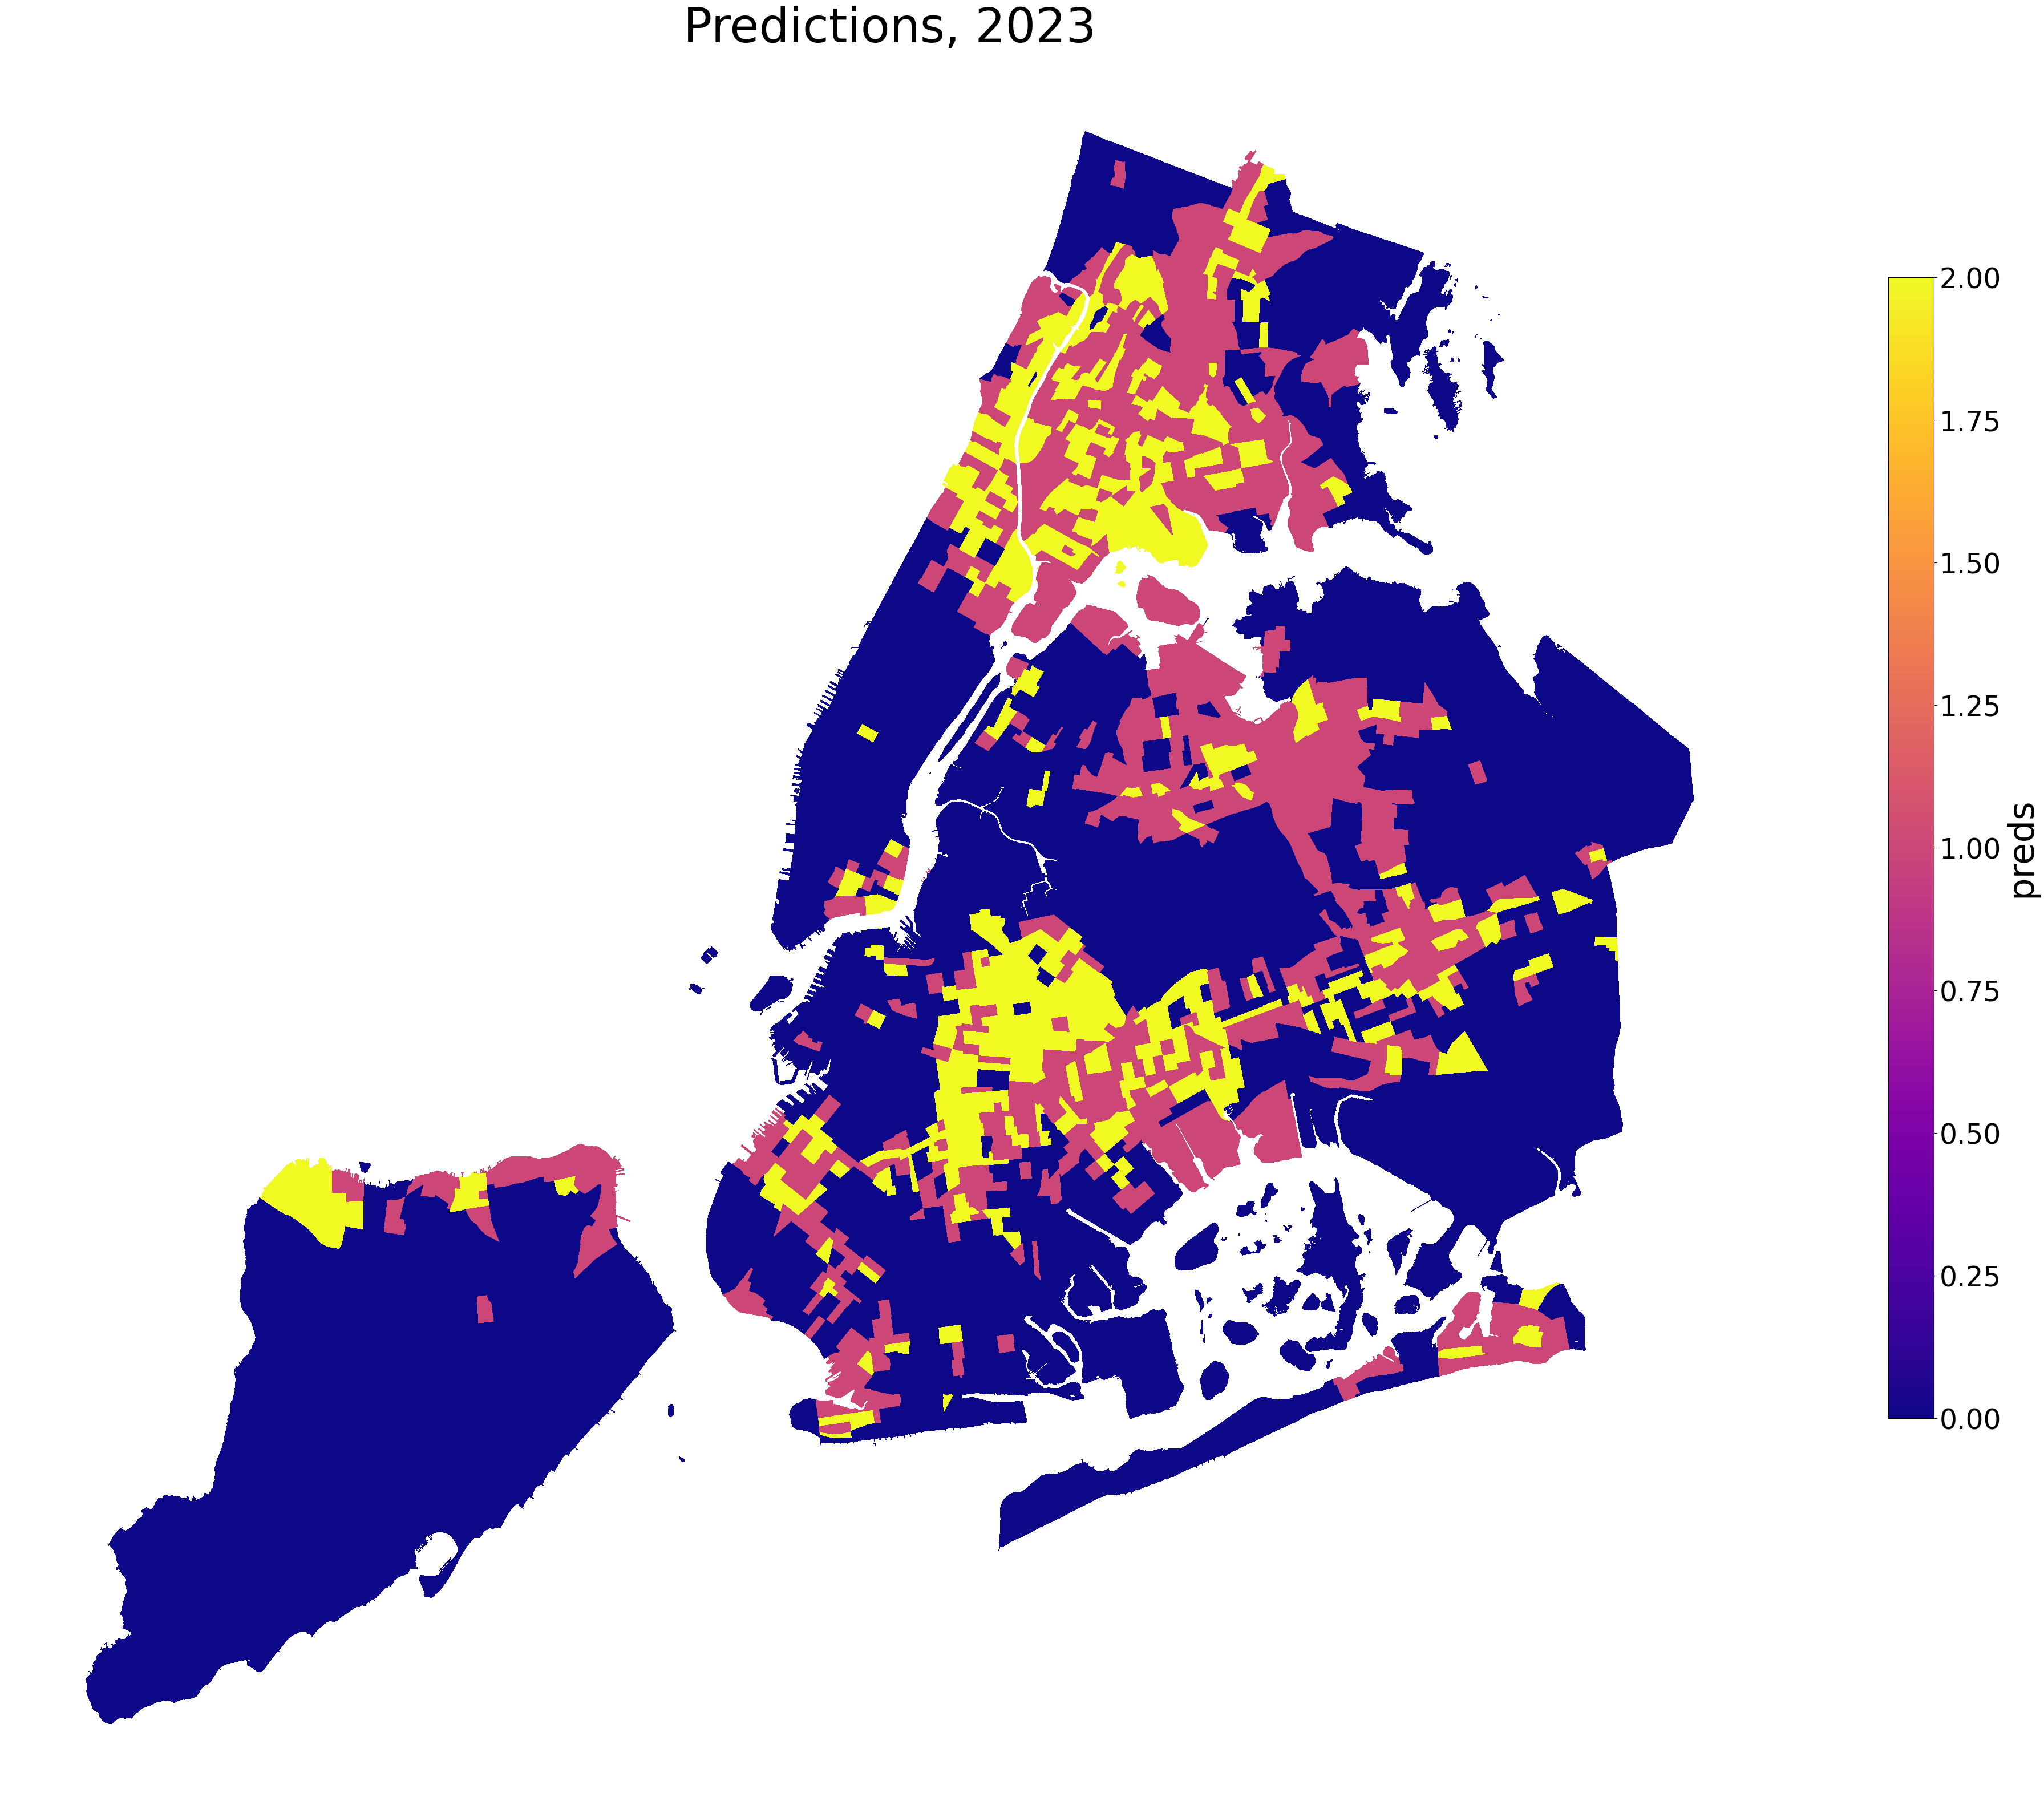

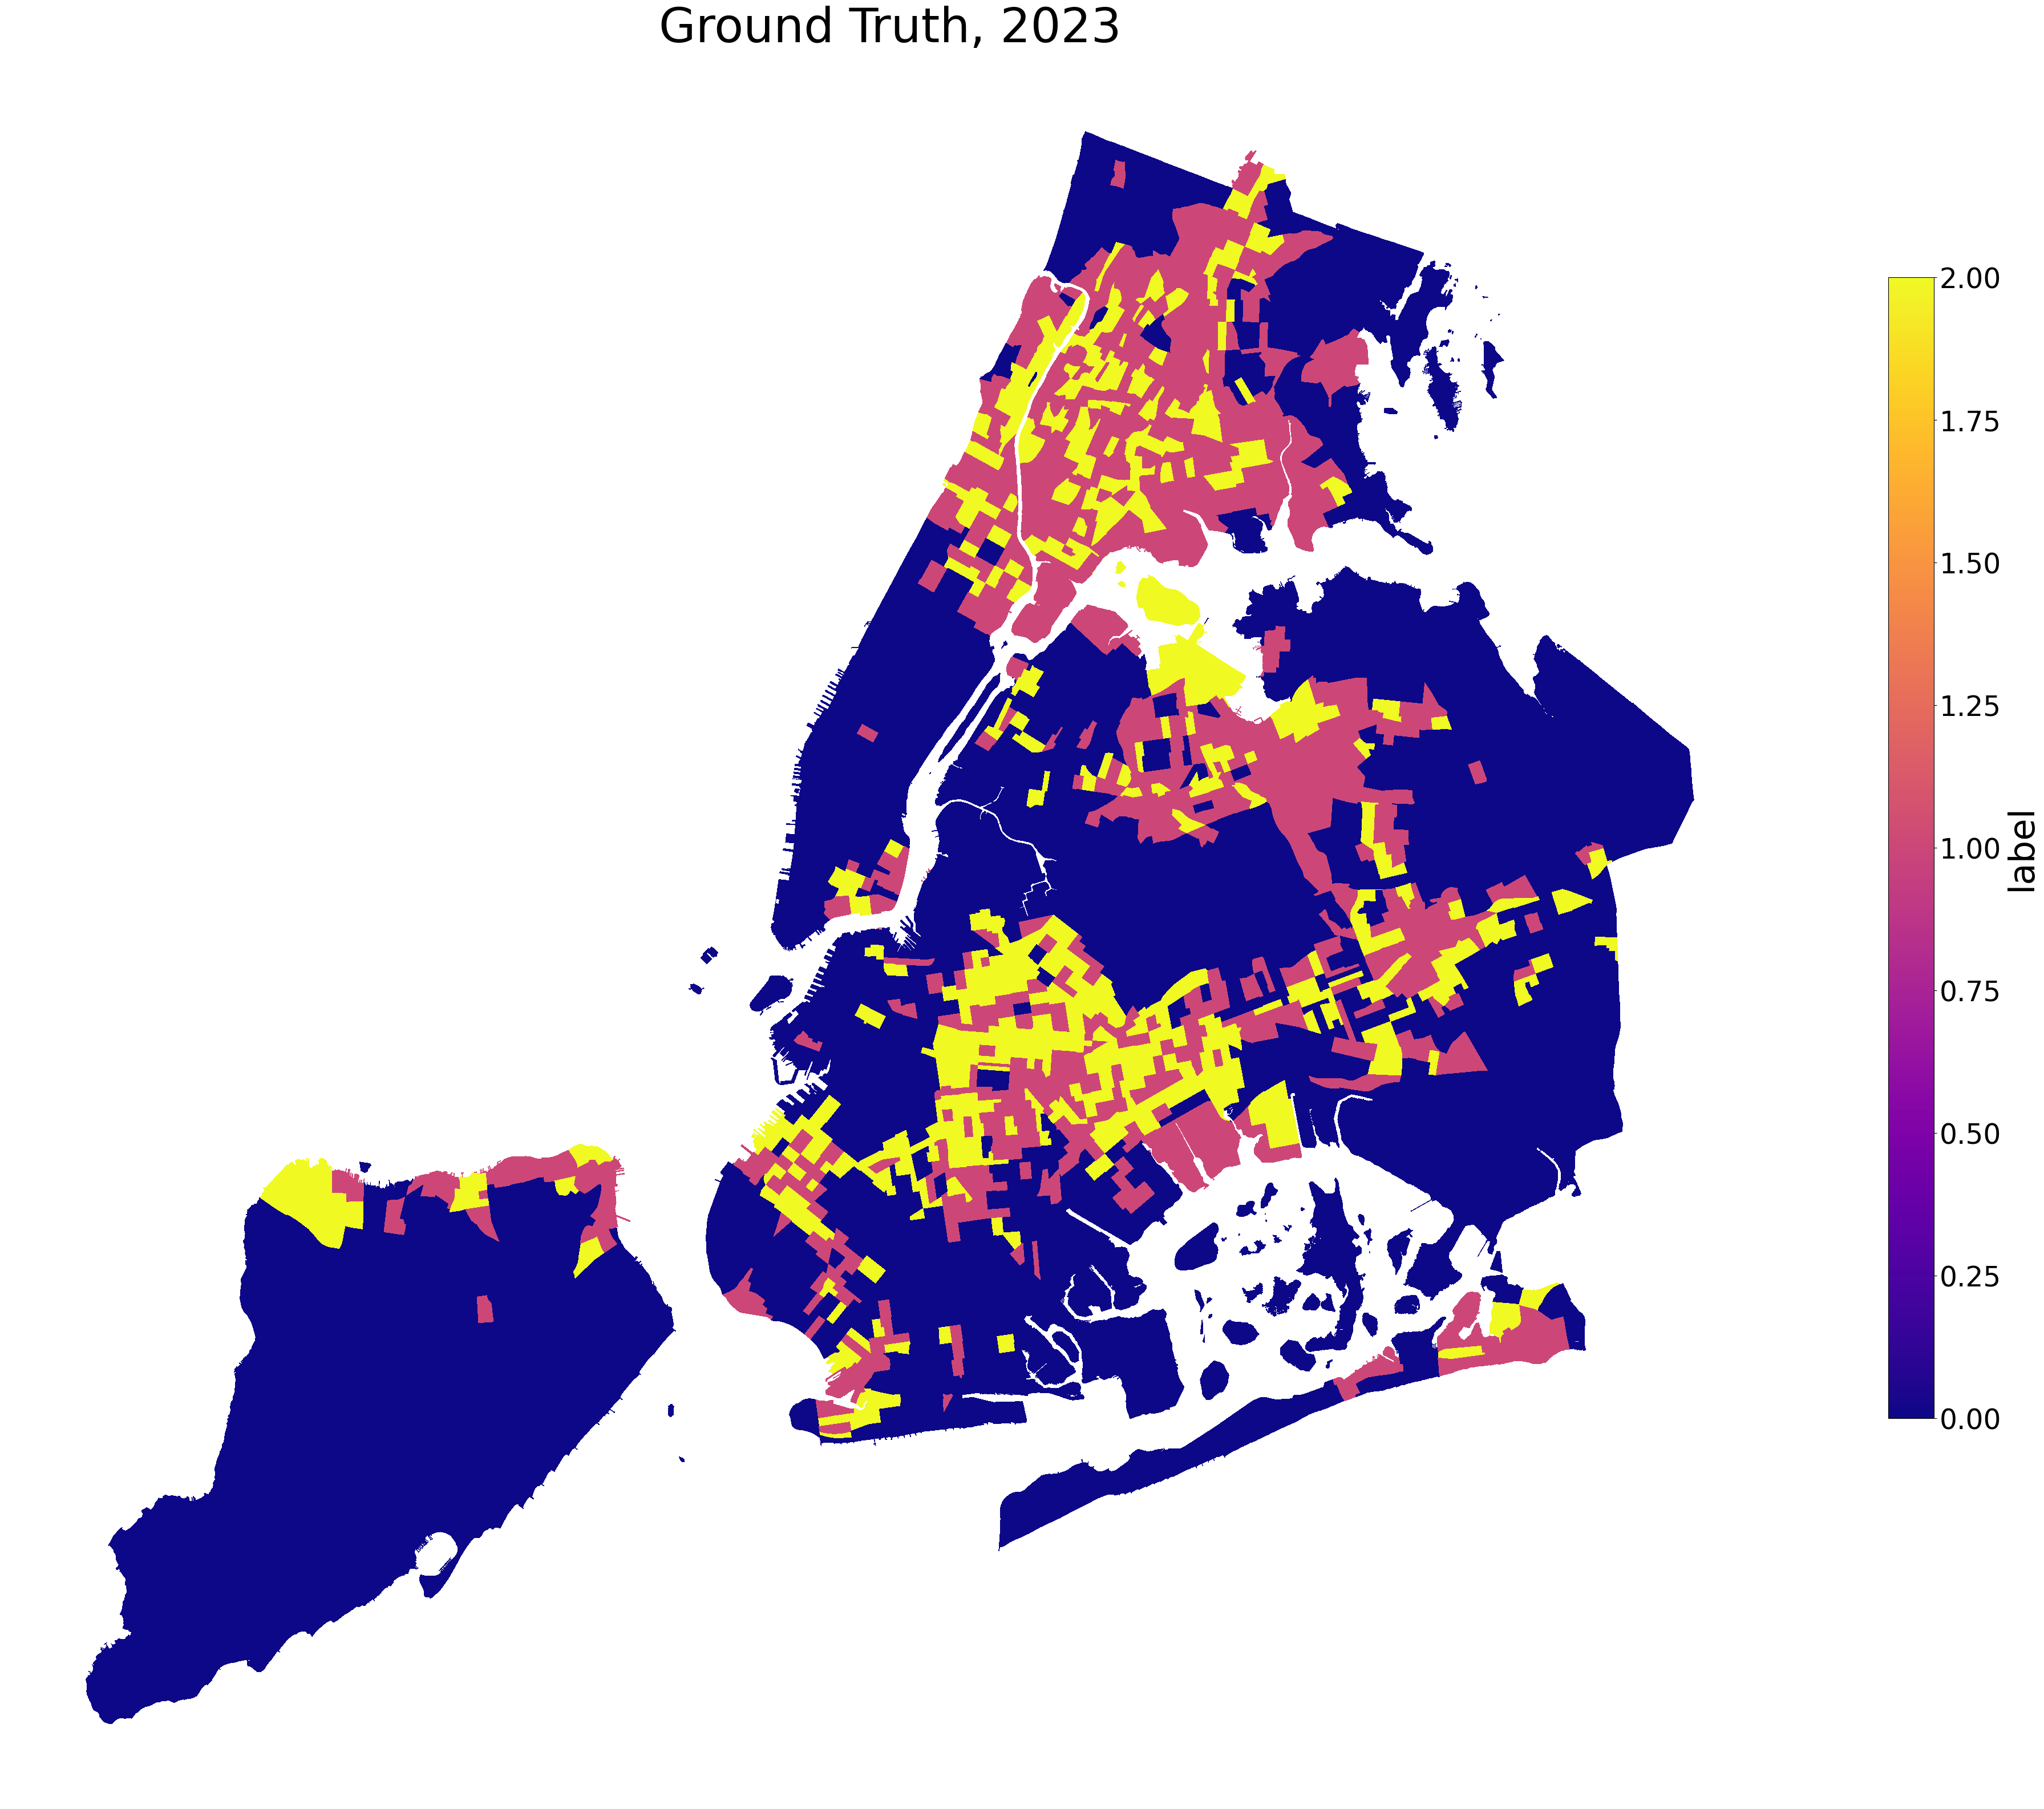

In [31]:
# 2023 test set preds

test_set['preds'] = y_test_pred
test_set_full = pd.concat([test_set, test_set_full[test_set_full.label==0]])
test_set_full['year'] = '2023'
test_set_full['preds'].fillna(0, inplace=True)

# visualize preds
choropleth(test_set_full,'preds',['2023'], cmap='plasma',title='Predictions')
choropleth(test_set_full,'label',['2023'], cmap='plasma',title='Ground Truth')

In [6]:
# 2027 final preds - retrain on full training data

X = pred_set[feat]
y_final_pred = forest.predict(X)
pred_set['preds'] = y_final_pred
pred_set['preds'] = np.where(pred_set['label']==0, 0, pred_set['preds'])
pred_set['year'] = '2027'

# visualize preds
choropleth(pred_set,'preds',['2027'], cmap='plasma',title='Predictions')

/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_40927/3748026332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_set['preds'] = y_final_pred
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_40927/3748026332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_set['preds'] = np.where(pred_set['label']==0, 0, pred_set['preds'])
/var/folders/w0/4r14_1sj0j7fl6nz7v1nwgkr0000gp/T/ipykernel_40927/3748026332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

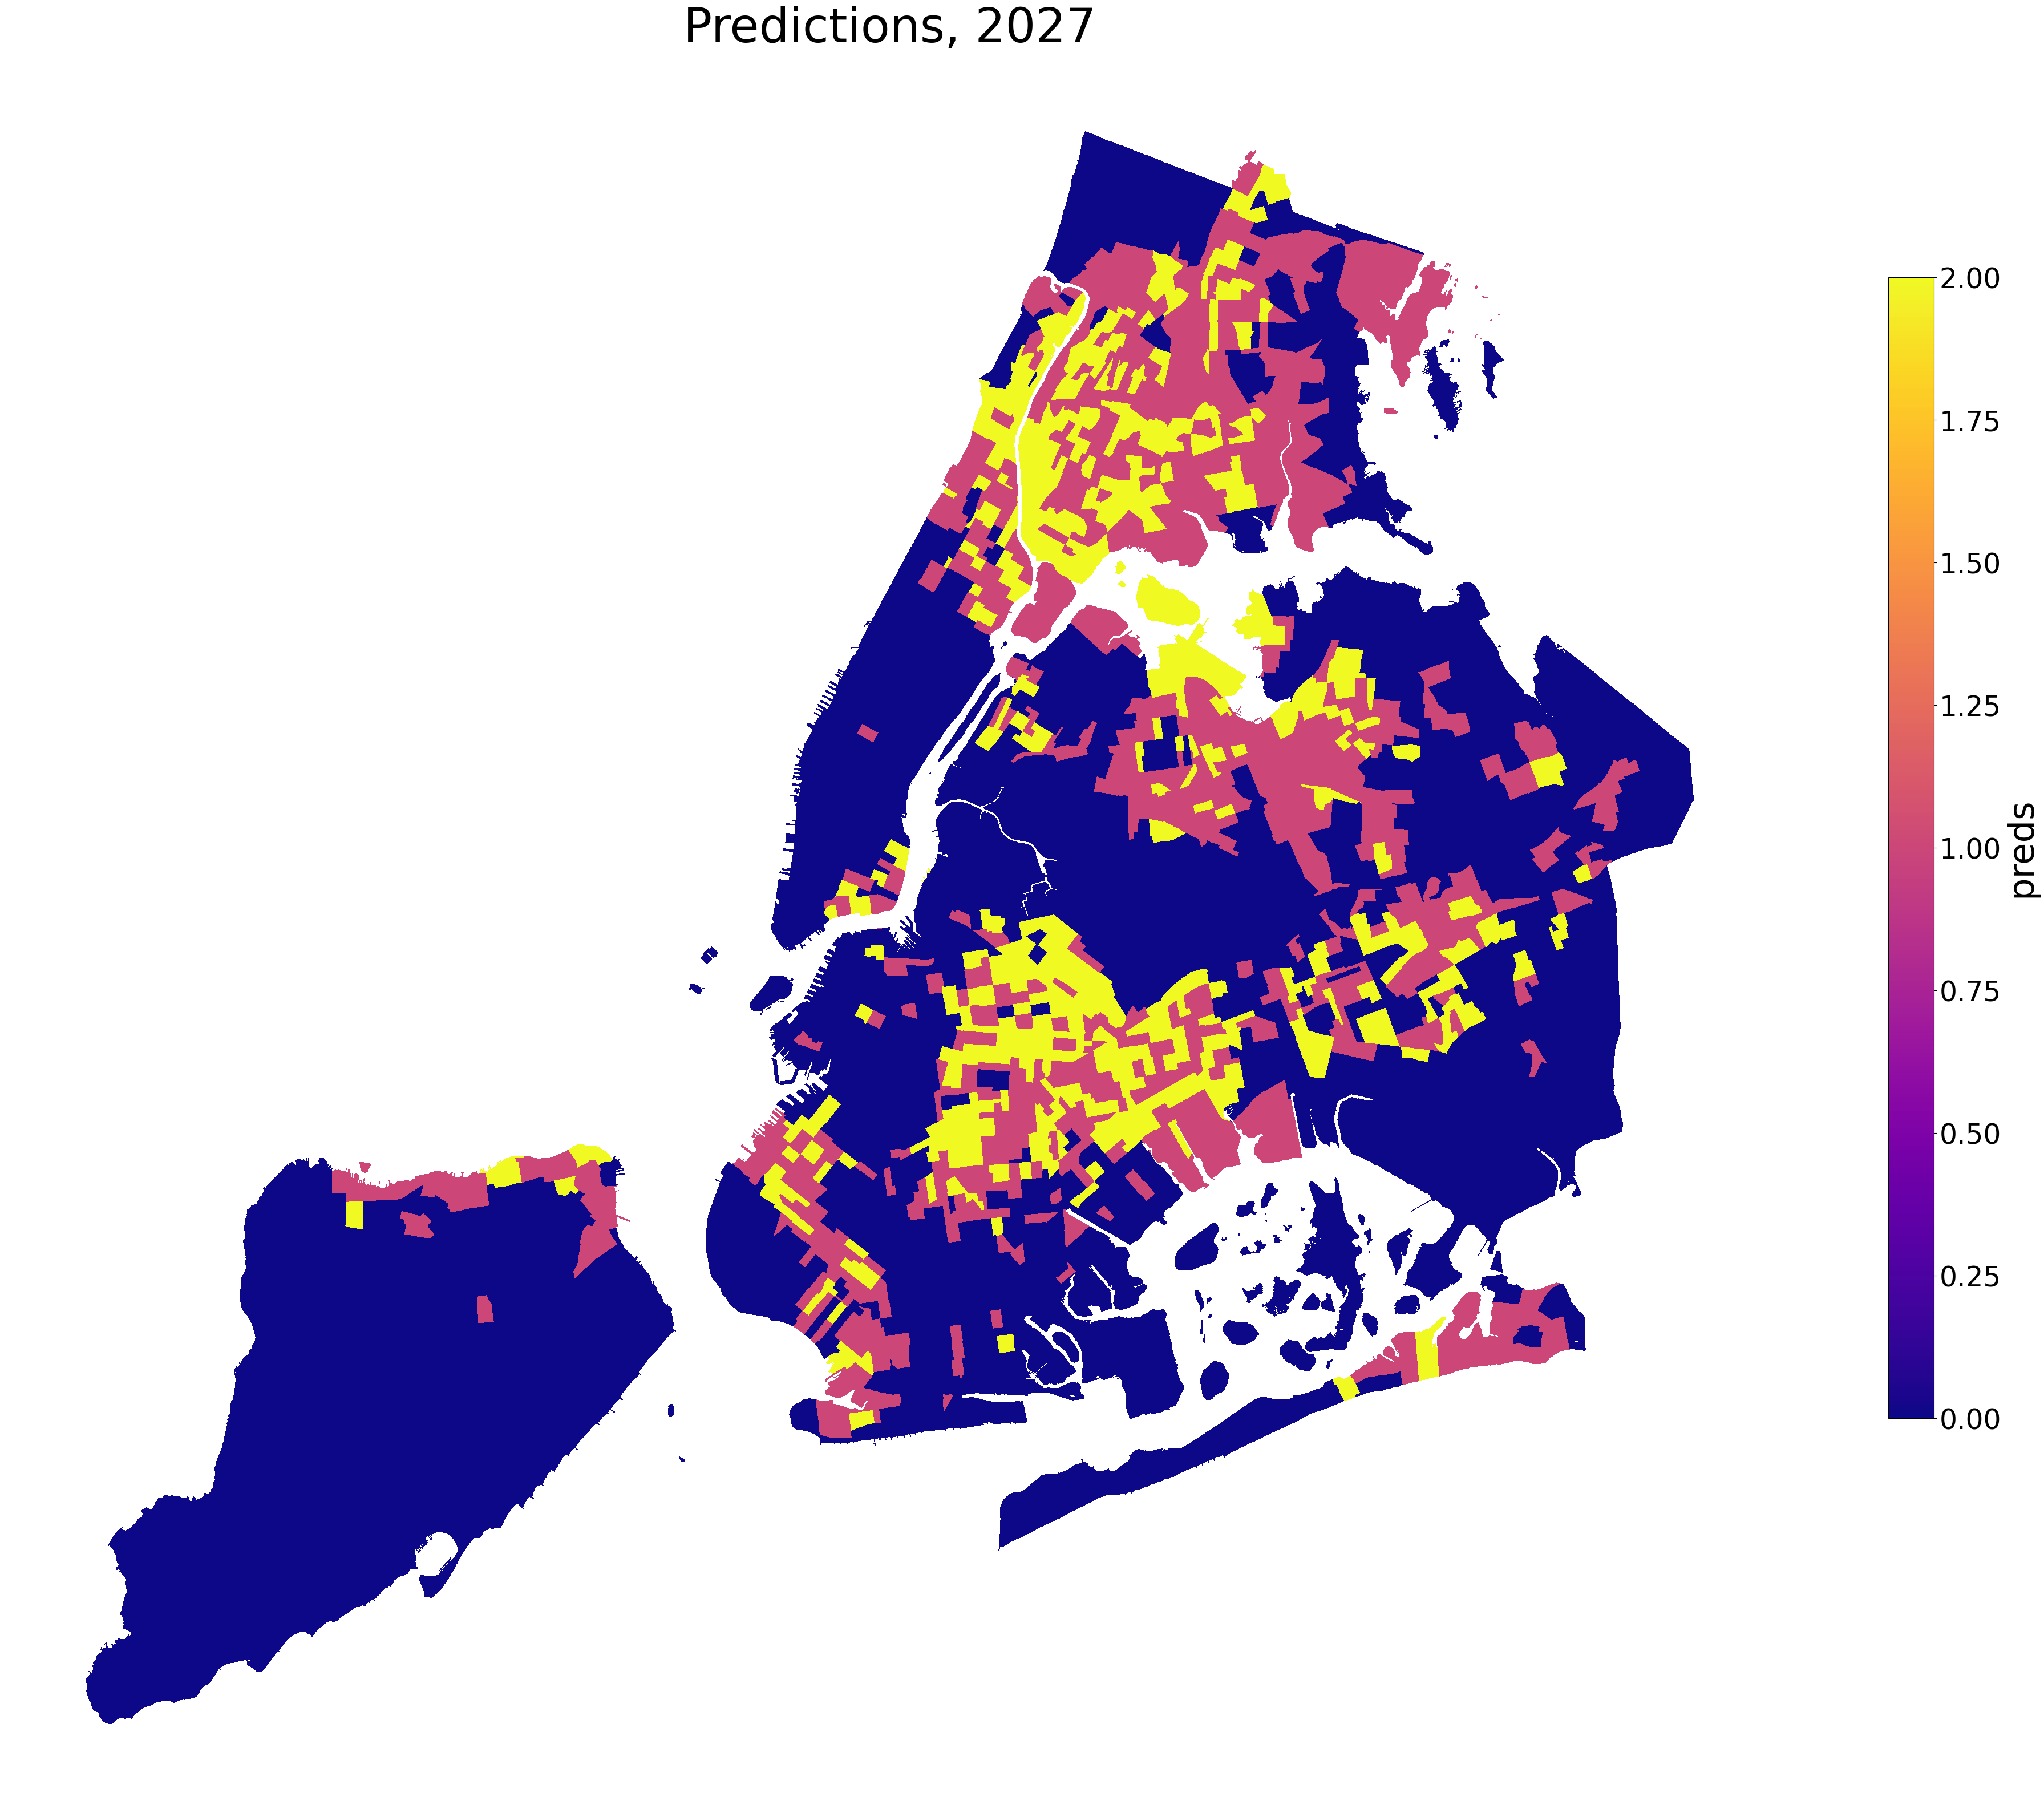

In [74]:
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_train_pred = logreg.predict(X_train)
# y_test_pred = logreg.predict(X_test)

# kf = KFold(n_splits=5, shuffle=True)
# cv_scores = cross_val_score(logreg, X, y, cv=kf, scoring="f1")
# print("CV Scores:", cv_scores)
# print("Mean F1:", np.mean(cv_scores))




# train_score = accuracy_score(y_train, y_train_pred)
# test_score =  accuracy_score(y_test, y_test_pred)
# print("Train Precision:", train_score)
# print("Test Precision:", test_score)


In [118]:
sorted(list(zip(forest.feature_importances_, X_train.columns)), reverse=True)

[(0.06994119920545669, 'percent_grad'),
 (0.056862876864707174, 'percent_bachelors'),
 (0.054391434334432415, 'med_income'),
 (0.03663511374903111, 'med_rent'),
 (0.03080461650063674, 'percent_public_transit'),
 (0.026408557726952147, 'percent_hh_english'),
 (0.025600004733675817, 'med_value'),
 (0.02489350098856186, 'med_rent_acs'),
 (0.02422369963152492, 'percent_drive_commute'),
 (0.023247254813219844, 'percent_latino'),
 (0.023149281655712218, 'percent_hh_snap'),
 (0.021958697857033527, 'num_trees'),
 (0.020739836547624475, 'percent_hh_rented'),
 (0.020580145906653195, 'percent_white'),
 (0.020508468713624967, 'percent_work_finance'),
 (0.020331489579598107, 'percent_asian'),
 (0.01970005812210092, 'percent_naturalized_citizen'),
 (0.01956480782802811, 'percent_moved_within_county'),
 (0.01924629312785391, 'percent_work_construction'),
 (0.01904129117778758, 'num_evictions_residential'),
 (0.018686194715460104, 'percent_hh_income_assist'),
 (0.018490200196537725, 'percent_work_stem

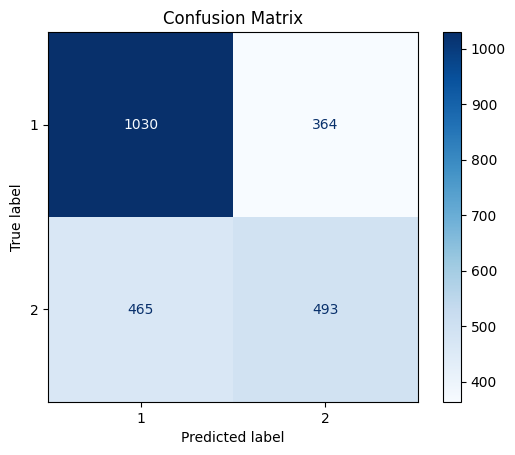

In [119]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test['label'].unique())
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()